Import des bibliothèque necessaires

In [20]:
# Importations standard
import json
import string
import re

# Importations de bibliothèques tierces
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns

# Importations des modules sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import f1_score, confusion_matrix

# Importations nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

# Vérifier et télécharger les ressources nltk si nécessaires
nltk_resources = ['stopwords', 'punkt', 'wordnet']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}' if resource == 'punkt' else f'corpora/{resource}')
    except LookupError:
        nltk.download(resource)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\d.truong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Classe Data pour tous les pré-traitement, vectorisation et réduction de la matrice.

In [21]:
class Data:
    def __init__(self, limit=5000, language="french", text_column="texte_annonce", test=False):
        if test==True:
            self.data = (pd.read_json("test.jsonl", lines=True)[["texte_annonce","OGC_FID"]])
        else:
            self.data = (pd.read_json("train.jsonl", lines=True)[["texte_annonce", "cal_réponse_signalement"]]).iloc[:limit]
            self.data["cal_réponse_signalement"] = self.data["cal_réponse_signalement"].map({"Pris en compte": 0,"Rejete (hors specs)": 1})
        self.text_column = text_column
        self.language = language


    def get_data(self):
        return self.data

    def supprimer_stopwords(self):
        stop_words = stopwords.words(self.language)
        
        def nettoyer_texte(texte):
            texte = re.sub(r'[^\w\s]', '', texte)  # Retirer la ponctuation
            texte = re.sub(r'\d+', '', texte)      # Retirer les chiffres
            tokens = nltk.word_tokenize(texte.lower())
            return ' '.join([word for word in tokens if word not in stop_words])
        
        # Appliquer la fonction de nettoyage à la colonne texte
        self.data[self.text_column] = self.data[self.text_column].apply(nettoyer_texte)
        
    def rien(self, x):
        pass

    def racinisation(self, ignore_stopwords=None):
        stemmer = SnowballStemmer(self.language)
        self.data[self.text_column] = self.data[self.text_column].apply(lambda x: ' '.join([stemmer.stem(word) for word in str(x).split()]))
        self.supprimer_stopwords()

    def lemmatisation(self, mode=None, overwrite=None):
        lemmatizer = WordNetLemmatizer()
        if mode:
            lemmatizer.mode = mode
        if overwrite:
            lemmatizer.overwrite = overwrite
        self.data[self.text_column] = self.data[self.text_column].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in str(x).split()]))
        self.supprimer_stopwords()

    def vectorisation_simple(self, ngram_range=None, max_features=None):
        vectorizer = CountVectorizer()
        if ngram_range:
            vectorizer.ngram_range = ngram_range
        if max_features:
            vectorizer.max_features = max_features
        vect_data = vectorizer.fit_transform(self.data[self.text_column])
        vect_df = pd.DataFrame(vect_data.toarray(), columns=vectorizer.get_feature_names_out())
        self.data = pd.concat([vect_df, self.data.iloc[:, -1]], axis=1)

    def vectorisation_ponderee(self, ngram_range=None, max_features=None, norm=None):
        vectorizer = TfidfVectorizer()
        if ngram_range:
            vectorizer.ngram_range = ngram_range
        if max_features:
            vectorizer.max_features = max_features
        if norm:
            vectorizer.norm = norm
        vect_data = vectorizer.fit_transform(self.data[self.text_column])
        vect_df = pd.DataFrame(vect_data.toarray(), columns=vectorizer.get_feature_names_out())
        self.data = pd.concat([vect_df, self.data.iloc[:, -1]], axis=1)

    def reduction_svd(self, n_components=None, n_iter=None):
        svd = TruncatedSVD()
        if n_components:
            svd.n_components = n_components
        if n_iter:
            svd.n_iter = n_iter
        svd = TruncatedSVD(n_components=n_components)
        svd_result = svd.fit_transform(self.data.iloc[:, :-1])
        self.data = pd.concat([pd.DataFrame(svd_result), self.data.iloc[:, -1]], axis=1)

    def reduction_nmf(self, n_components=200, init=None):
        nmf = NMF(n_components=n_components)
        if init:
            nmf.init = init
        nmf_result = nmf.fit_transform(self.data.iloc[:, :-1])
        self.data = pd.concat([pd.DataFrame(nmf_result), self.data.iloc[:, -1]], axis=1)

    def process_and_export(self, n_components=100):
        # Définir toutes les combinaisons possibles
        preprocessing_methods = [self.rien, self.racinisation, self.lemmatisation]
        vectorisation_methods = [self.vectorisation_simple, self.vectorisation_ponderee]
        reduction_methods = [self.reduction_svd, self.reduction_nmf]

        combinations = product(preprocessing_methods, vectorisation_methods, reduction_methods)

        # Boucler sur toutes les combinaisons
        for i, (preprocess, vectorize, reduce) in enumerate(combinations):
            # Réinitialiser les données à l'état brut
            self.data = self.data_brut.copy()

            # Appliquer les méthodes
            preprocess(self.text_column)
            vectorize(self.text_column)
            reduce(n_components)

            # Exporter le résultat
            output_file = f"output_combination_{i+1}.jsonl"
            self.data.to_json(output_file, orient="records", lines=True)
            print(f"Exporté : {output_file}")


Classe global des classifieurs permettant de faire de l'héritage

In [22]:
class Classifieur:
    def __init__(self, data):
        # Chargement et découpage des données
        self.chargement(data)
        self.decoupage()

    def chargement(self, data):
        # Chargement des données et séparation X, y
        self.data = data
        self.X = data.iloc[:, :-1]  # Toutes les colonnes sauf la dernière (X)
        self.y = data.iloc[:, -1]   # Dernière colonne (y)

    def decoupage(self):
        # Découpage en jeu d'entrainement et test
        self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(self.X, self.y, test_size=0.6, random_state=0)

    def entrainement(self):
        pass

    def rien(self):
        pass

    def taux_reussite(self):
        # Calcul du taux de réussite
        y_pred = self.classifier.predict(self.X_test)
        accuracy = accuracy_score(self.Y_test, y_pred)
        return f"{accuracy:.3f}"

    def f1_score(self):
        # Calcul du F1-score
        from sklearn.metrics import f1_score
        y_pred = self.classifier.predict(self.X_test)
        f1 = f1_score(self.Y_test, y_pred, average='weighted')

         # Visualisation de la matrice de confusion
        plt.figure(figsize=(8, 6))

        cm = confusion_matrix(self.Y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=self.y.unique(), yticklabels=self.y.unique())
        plt.title('Matrice de Confusion')
        plt.xlabel('Prédictions')
        plt.ylabel('Vraies valeurs')
        plt.show()
        return f"{f1:.3f}"
    
    def predict(self, data, output_csv_path):
        X = data.iloc[:, :-1]  
        ogc = data.iloc[:, -1] 

        y_pred = self.classifier.predict(X)  
        y_pred = pd.Series(y_pred, name="cal_réponse_signalement")
        y_pred = y_pred.map({0: "Pris en compte", 1: "Rejeté (hors specs)"})

        result = pd.concat([ogc, y_pred], axis=1)
        result.to_csv(output_csv_path, index=False)

        return result


    def recherche_hyperparametres(self,param_grid):
          # Recherche des meilleurs hyperparamètres avec GridSearchCV
          grid_search = GridSearchCV(
              self.classifier,
              param_grid,
              cv=5,  # Validation croisée 5-fold
              scoring='f1',
          )
          grid_search.fit(self.X_train, self.Y_train) # tres important de preciser le label posit
          self.classifier = grid_search.best_estimator_ # Automatiquement garde le meilleur classifieur
          print("Meilleurs hyperparamètres :", grid_search.best_params_)


In [23]:
from sklearn.naive_bayes import MultinomialNB


class Multinomial(Classifieur):
    def __init__(self, data, alpha = None, fit_prior = None):
        super().__init__(data)
        self.classifier = MultinomialNB()
        if alpha : self.classifier.alpha = alpha
        if fit_prior : self.classifier.fit_prior = fit_prior

    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)


In [24]:
from sklearn.naive_bayes import BernoulliNB


class Bernoulli(Classifieur):
    def __init__(self, data, alpha = None, fit_prior = None, binarize = None):
        super().__init__(data)

        self.classifier = BernoulliNB()
        if alpha : self.classifier.alpha = alpha
        if fit_prior : self.classifier.fit_prior = fit_prior
        if binarize : self.classifier.binarize = binarize


    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)

In [25]:
from sklearn.naive_bayes import GaussianNB


class Gaussian(Classifieur):
    def __init__(self, data, var_smoothing = None):
        super().__init__(data)
        self.classifier = GaussianNB()
        if var_smoothing : self.classifier.var_smoothing = var_smoothing

    def entrainement(self):
        # Entraînement du modèle avec les données
        self.classifier.fit(self.X_train, self.Y_train)

In [26]:
from sklearn.linear_model import LogisticRegression

class RegressionLogistique(Classifieur):
    def __init__(self, data, penalty = None, C = None, solver = None, max_iter = None, l1_ratio = None, random_state = None):
        super().__init__(data)
        self.classifier = LogisticRegression()
        if penalty : self.classifier.penalty = penalty
        if C : self.classifier.C = C
        if solver : self.classifier.solver = solver
        if max_iter : self.classifier.max_iter = max_iter
        if l1_ratio : self.classifier.l1_ratio
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [27]:
from sklearn.neighbors import KNeighborsClassifier

class KPlusProchesVoisins(Classifieur):
    def __init__(self, data, n_neighbors = 3, weights = None, algorithm = None, p = None):
        super().__init__(data)

        self.classifier = KNeighborsClassifier()
        if n_neighbors : self.classifier.n_neighbors = n_neighbors
        if weights : self.classifier.weights = weights
        if algorithm : self.classifier.algorithm = algorithm
        if p : self.classifier.p = p

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [28]:
from sklearn.tree import DecisionTreeClassifier

class ArbreDeDecision(Classifieur):
    def __init__(self, data, criterion = None, max_depth = None, min_samples_split = None, min_samples_leaf = None, max_features = None, ccp_alpha = None, random_state = None):
        super().__init__(data)
        self.classifier = DecisionTreeClassifier()
        if criterion : self.classifier.criterion = criterion
        if max_depth : self.classifier.max_depth = max_depth
        if min_samples_split : self.classifier.min_samples_split = min_samples_split
        if min_samples_leaf : self.classifier.min_samples_leaf = min_samples_leaf
        if max_features : self.classifier.max_features = max_features
        if ccp_alpha : self.classifier.ccp_alpha = ccp_alpha
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


In [29]:
from sklearn.ensemble import RandomForestClassifier

class ForetAleatoire(Classifieur):
    def __init__(self, data, n_estimators = 100, criterion = None, max_depth = None, min_samples_split = None, min_samples_leaf = None, max_features = None, bootstrap = None, ccp_alpha = None, random_state = 0 ):
        super().__init__(data)
        self.classifier = RandomForestClassifier()
        if n_estimators : self.classifier.n_estimators = n_estimators
        if criterion : self.classifier.criterion = criterion
        if max_depth : self.classifier.max_depth = max_depth
        if min_samples_split : self.classifier.min_samples_split = min_samples_split
        if min_samples_leaf : self.classifier.min_samples_leaf = min_samples_leaf
        if max_features : self.classifier.max_features = max_features
        if bootstrap : self.classifier.bootstrap = bootstrap
        if ccp_alpha : self.classifier.ccp_alpha = ccp_alpha
        if random_state : self.classifier.random_state = random_state

    def entrainement(self):
        self.classifier.fit(self.X_train, self.Y_train)


Fonction ultra débile qui teste tous les classifieurs, pré traitements, vectorisation et réduction afin d'avoir le meilleurs taux de réussite.

In [30]:
def possibilite():
    results = []  # Liste pour stocker les résultats

    with open("hyperpamètres_classifieur.jsonl","r") as file:
        hyper_classifieur = json.load(file)

    for x in ["lemmatisation", "racinisation","rien"]:
            data = Data(limit=100)
            if x == "lemmatisation" :
                for mode in ["lookup", "rule"]:
                  for overit in [True, False]:
                    data.lemmatisation(mode,overit)
                    print("etape 1")
                    data.vectorisation_ponderee()
                    print("etape 2")
                    for y in ["nmf","svd" ]:
                      if y == "nmf":
                          data.reduction_nmf(n_components = 100)
                          print("etape 3")
                          z = "nmf"
                      else:
                          data.reduction_svd(n_components = 100)
                          print("etape 4")
                          z = "svd"
#Meilleurs hyperparamètres : {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
                      # Parcours des classifieurs
                      for i in [ForetAleatoire]:
                          classifieur = i(data.get_data())
                          param_opti = classifieur.recherche_hyperparametres(hyper_classifieur["RandomForestClassifier"])
                          classifieur = i(data.get_data(),max_depth=param_opti["max_depth"], min_samples_leaf = param_opti["min_samples_leaf"], min_samples_split = param_opti["min_samples_split"], n_estimators=param_opti["min_samples_split"] )
                          taux_reussite = classifieur.taux_reussite()
                          f1_score = classifieur.f1_score()

                          # Ajout des résultats à la liste sous forme de tuple
                          results.append(x, mode, overit, y, z, i.__name__, taux_reussite,f1_score)
                          print(results[len(results)])


            elif x == "racinisation" :
              for stop_word in [True, False]:
                data.racinisation(stop_word)
                data.vectorisation_ponderee()
                for y in ["vectorisation_ponderee","vectorisation_simple"]:
                      if y == "vectorisation_ponderee":
                          data.reduction_nmf(n_components = 100)
                          z = "nmf"
                      else:
                          data.reduction_svd(n_components = 100)
                          z = "svd"

                      # Parcours des classifieurs
                      for i in [ForetAleatoire]:
                          classifieur = i(data.get_data())
                          param_opti = classifieur.recherche_hyperparametres(hyper_classifieur["RandomForestClassifier"])
                          classifieur = i(data.get_data(),max_depth=param_opti["max_depth"], min_samples_leaf = param_opti["min_samples_leaf"], min_samples_split = param_opti["min_samples_split"], n_estimators=param_opti["min_samples_split"] )
                          taux_reussite = classifieur.taux_reussite()
                          f1_score = classifieur.f1_score()

                          # Ajout des résultats à la liste sous forme de tuple
                          results.append((x, mode, overit, y, z, i.__name__, taux_reussite,f1_score))
                          print(results[len(results)])

    # Tri des résultats par taux de réussite (du plus élevé au plus faible)
    results_sorted = sorted(results, key=lambda x: x[6], reverse=True)

    # Affichage des résultats triés
    for res in results_sorted:
        print(f"{res[0]} - {res[1]} - {res[2]} - {res[3]} - {res[4]} - {res[5]} : {res[6]}")

possibilite()

FileNotFoundError: [Errno 2] No such file or directory: 'hyperpamètres_classifieur.jsonl'

Exportation Kaggle

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

data = Data(test=True)
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=200)
data_test=data.get_data()
print("data_tester terminé")

data = Data()
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf(n_components=200)
data_train=data.get_data()
print("data_entainement terminer")

foret = ForetAleatoire(data_train)
foret.recherche_hyperparametres(param_grid)
print("hyperparametre_termine")
foret.f1_score()
fichier=foret.predict(data_test)
print("prediction terminer")


c:\Users\d.truong\AppData\Local\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


data_tester terminé


c:\Users\d.truong\AppData\Local\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


data_entainement terminer


Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
hyperparametre_termine


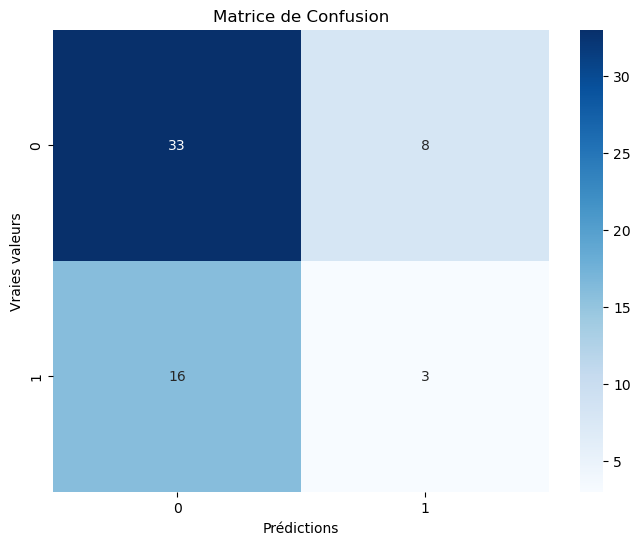

prediction terminer


In [17]:
foret = ForetAleatoire(data_train)
foret.recherche_hyperparametres(param_grid)
print("hyperparametre_termine")
foret.f1_score()
fichier=foret.predict(data_test)
print("prediction terminer")

Exemple d'utilisation en temps normal pour l'optimisation

c:\Users\Brasi\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


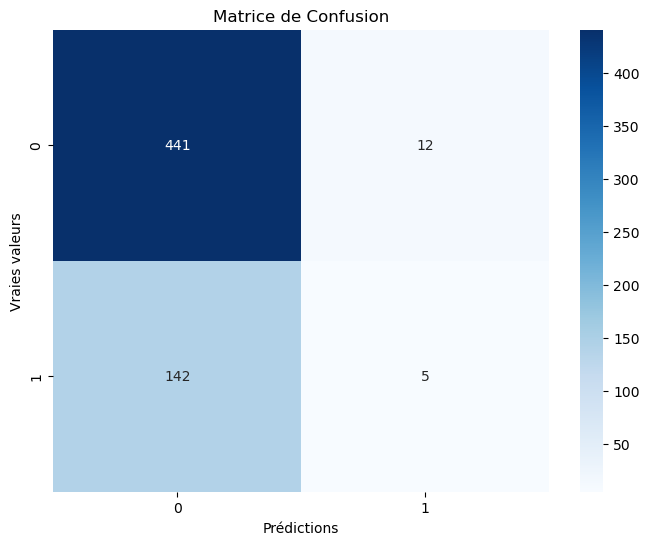

0.658


In [45]:
data = Data(limit=1000)
data.lemmatisation()
data.vectorisation_ponderee()
data.reduction_nmf()
data = data.get_data()

foret = ForetAleatoire(data)
foret.entrainement()
print(foret.f1_score())

Optimisation de la foret

etape 1
etape 2
etape 3
etape 4
etape 5
etape 6
Meilleurs hyperparamètres : {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
etape 7


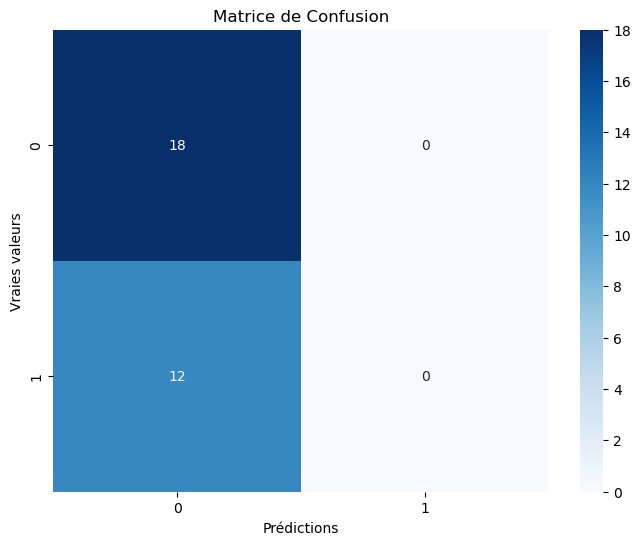

'0.450'

In [46]:
#Donne les meilleurs hyperparametre de la foret
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

data = Data(limit = 50)
print("etape 1")
data.lemmatisation()
print("etape 2")
data.vectorisation_ponderee()
print("etape 3")
data.reduction_nmf()
print("etape 4")
data = data.get_data()
print("etape 5")

foret = ForetAleatoire(data)
print("etape 6")
foret.recherche_hyperparametres(param_grid)
print("etape 7")
foret.f1_score()
